# Lecture 10

## Introduction to [Regressions](#regression) <a class="anchor" id="TOC"></a>

 - binary means (close vs far)         
 - pre-specified categories with means 
 - non-parametric regression (lowess)  
 - simple linear regression (OLS)  
 - analysis of the results
 - Log models
 - Non-linear models
                                     
#### Case-study:                           
- Hotels Vienna          
                                     
#### Dataset:                              
- hotels-vienna


___

## Introduction to Regression<a class = 'anchor' id = 'regression'></a>

Import packages

In [1]:
import warnings

import numpy as np
import pandas as pd
import patchworklib as pw
from plotnine import *
from skimpy import skim

%matplotlib inline
warnings.filterwarnings("ignore")

From OSF import hotel-vienna data

In [2]:
hotels = pd.read_csv("https://osf.io/y6jvb/download")

In [3]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,offer_cat,year,month,weekend,holiday,distance,distance_alter,accommodation_type,nnights,rating
0,Austria,Vienna,36.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,4.5,...,15-50% offer,2017,11,0,0,2.7,4.4,Apartment,1,4.4
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1-15% offer,2017,11,0,0,1.7,3.8,Hotel,1,3.9
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.4,2.5,Hotel,1,3.7
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,15-50% offer,2017,11,0,0,1.7,2.5,Hotel,1,4.0
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.2,2.8,Hotel,1,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,Austria,Vienna,2.0,City centre,Donauturm,Wieden,109,Vienna,3.0,3.0,...,50%-75% offer,2017,11,0,0,1.5,3.8,Apartment,1,5.0
424,Austria,Vienna,145.0,City centre,Donauturm,Wieden,185,Vienna,5.0,4.0,...,15-50% offer,2017,11,0,0,0.8,3.6,Hotel,1,4.3
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,0% no offer,2017,11,0,0,1.0,3.7,Hotel,1,4.4
426,Austria,Vienna,169.0,City centre,Donauturm,Wieden,58,Vienna,3.0,3.0,...,15-50% offer,2017,11,0,0,1.4,4.1,Hotel,1,3.2


Apply filters:  3-4 stars, Vienna actual, without  extreme prices

In [4]:
hotels = (
    hotels.loc[lambda x: x["accommodation_type"] == "Hotel"]
    .loc[lambda x: x["city_actual"] == "Vienna"]
    .loc[lambda x: x["stars"] >= 3]
    .loc[lambda x: x["stars"] <= 4]
    .loc[lambda x: x["stars"].notnull()]
    .loc[lambda x: x["price"] <= 600]
)

Summary statistics on price and distance

In [5]:
hotels.filter(["price", "distance"]).describe(percentiles=[0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,25%,50%,75%,95%,max
price,207.0,109.975845,42.221381,50.0,82.0,100.0,129.5,183.4,383.0
distance,207.0,1.529952,1.161507,0.0,0.8,1.3,1.9,3.9,6.6


In [6]:
skim(hotels.filter(["price","distance"]))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 207    │ │ int64       │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA    ┃ NA %     ┃ mean     ┃ sd     ┃ p0    ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ price               │     0 │        0 │      110 │     42 │    50 │     82 │    130 │     380 │    █▅▁    │  │
│ │ distance            │     0 │        0 │      1.5 │    1.2 │     0 │    0.8 │    1.9 │     6.6 │   █▇▁▂    │  │
│ └─────────────────────┴───────┴──────────┴──────────┴────────┴───────┴────────┴────────┴─────────┴───────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Graphical investigation: \
create a base scatter-plot between price and distance

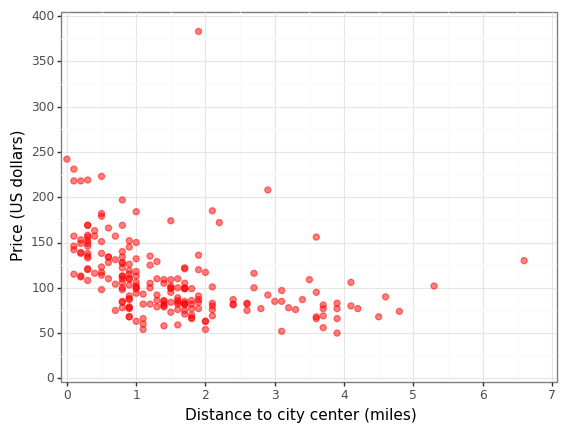

<ggplot: (677207453)>

In [7]:
p1 = (
    ggplot(data=hotels)
    + geom_point(aes(x="distance", y="price"), color="red", size=2, alpha=0.5)
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=range(0, 8))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)
p1

### Binary Variable

Close vs Far away hotels with a binary variable: 
 - if further away from 2 miles, consider as 'far', otherwise 'close'

In [8]:
hotels["dist2"] = np.where(hotels["distance"] >= 2, "Far", "Close")
hotels["Eprice_cat2"] = hotels.groupby("dist2")["price"].transform("mean")

Check the descriptives for the two categories:

In [9]:
(
    hotels.melt(id_vars="dist2", value_vars=["distance", "price"], value_name="price")
    .groupby(["dist2", "variable"])
    .agg(["mean", "std", "min", "max", "count"])
    .round(2)
)

price                          
                  mean    std   min    max count
dist2 variable                                  
Close distance    0.99   0.54   0.0    1.9   157
      price     116.43  43.10  54.0  383.0   157
Far   distance    3.21   0.97   2.0    6.6    50
      price      89.72  32.09  50.0  208.0    50

Plot the two categories

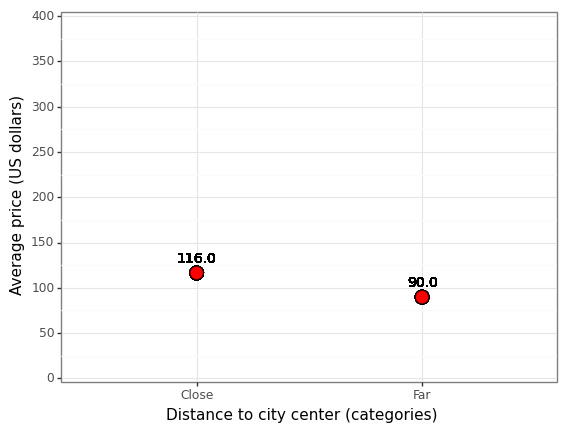

<ggplot: (677331089)>

In [10]:
(
    ggplot(data=hotels)
    + geom_point(
        aes(x="dist2", y="Eprice_cat2"), size=5, alpha=0.4, fill="red", na_rm=True
    )
    + geom_text(
        aes(x="dist2", y="Eprice_cat2 + 16", label="round(Eprice_cat2, 0)"),
        color="black",
        size=10,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + expand_limits(y=0.01)
    + scale_x_discrete()
    + labs(x="Distance to city center (categories)", y="Average price (US dollars)")
    + theme_bw()
)

#### Task:
Instead of a simple dot, use a box-plot, which shows the underlying (conditional) distribution better!

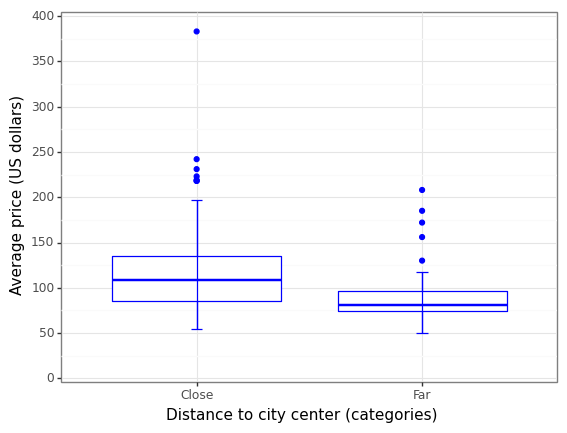

<ggplot: (677331288)>

In [11]:
(
    ggplot(hotels, aes(x="dist2", y="price"))
    + geom_boxplot(color="blue")
    + stat_boxplot(geom="errorbar", width=0.05, size=0.5, color="blue")
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + expand_limits(y=0.01)
    + scale_x_discrete()
    + labs(x="Distance to city center (categories)", y="Average price (US dollars)")
    + theme_bw()
)

###  Pre-specified Categories With Means (4 Distance Categories)

Below 1, between 1 and 2, between 2 and 3 and above 3 -> x value will be the midpoint

In [12]:
hotels["dist4"] = (
    0.5
    + np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 2.5, 0)
)

Add mean values for price given each group

In [13]:
hotels["Eprice_cat4"] = hotels.groupby("dist4")["price"].transform("mean")

In [14]:
(
    hotels.melt(id_vars="dist4", value_vars=["distance", "price"], value_name = "price")
    .groupby(["dist4", "variable"])
    .agg(["mean", "std", "min", "max", "count"])
    .round(2)
)

price                          
                  mean    std   min    max count
dist4 variable                                  
0.5   distance    0.55   0.28   0.0    0.9    81
      price     132.91  38.54  68.0  242.0    81
1.5   distance    1.46   0.29   1.0    1.9    76
      price      98.86  40.89  54.0  383.0    76
2.5   distance    2.35   0.32   2.0    2.9    22
      price      97.55  40.39  54.0  208.0    22
5.0   distance    3.88   0.76   3.0    6.6    28
      price      83.57  22.60  50.0  156.0    28

Make a graph for each segment

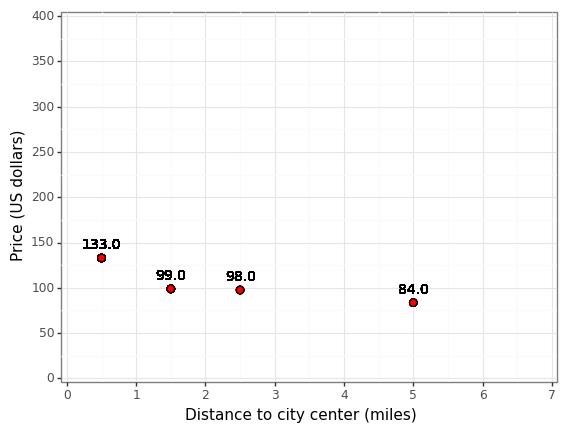

<ggplot: (678061451)>

In [15]:
(
    ggplot(data=hotels)
    + geom_point(
        aes(x="dist4", y="Eprice_cat4"), size=2.5, fill="red", alpha=0.4, na_rm=True
    )
    + geom_text(
        aes(x="dist4", y="Eprice_cat4 + 15", label="round(Eprice_cat4)"),
        color="black",
        size=10,
    )
    + expand_limits(x=0.01, y=0.01)
    + coord_cartesian(xlim=(0, 7), ylim=(0, 400))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 7), breaks=[0, 1, 2, 3, 4, 5, 6, 7]
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)

What actually is happening is a: \
scatterplot with step function (we use 1km bits for simplicity using 4 bits for 3-7km)

In [16]:
hotels["dist4_s"] = (
    np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 1, 0)
    + np.where(hotels["distance"] >= 4, 1, 0)
    + np.where(hotels["distance"] >= 5, 1, 0)
    + np.where(hotels["distance"] >= 6, 1, 0)
)

hotels["xend"] = hotels["dist4_s"] + 1
hotels["yend"] = hotels["Eprice_cat4"]

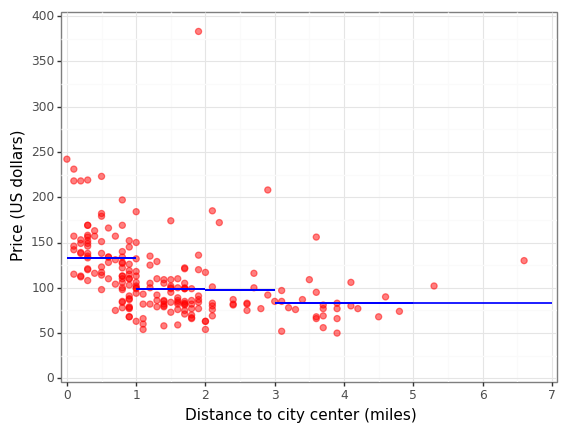

<ggplot: (678203323)>

In [17]:
p1 + geom_segment(
    aes(x="dist4_s", y="yend", xend="xend", yend="yend"),
    color="blue",
    size=0.7,
    na_rm=True,
)

#### Task

REGRESSION 3: use 7 different categories/bins based on distance: \
below 1, between:
          1 and 2
          2 and 3
          ...
          6 and 7

In [18]:
hotels["dist7_new"] = (
    0.5
    + np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 1, 0)
    + np.where(hotels["distance"] >= 4, 1, 0)
    + np.where(hotels["distance"] >= 5, 1, 0)
    + np.where(hotels["distance"] >= 6, 1, 0)
)

In [19]:
hotels["Eprice_cat7_new"] = hotels.groupby("dist7_new")["price"].transform("mean")

In [20]:
(
    hotels.melt(id_vars="dist7_new", value_vars=["distance", "price"], value_name = "price")
    .groupby(["dist7_new", "variable"])
    .agg(["mean", "std", "min", "max", "count"])
    .round(2)
)

price                           
                      mean    std    min    max count
dist7_new variable                                   
0.5       distance    0.55   0.28    0.0    0.9    81
          price     132.91  38.54   68.0  242.0    81
1.5       distance    1.46   0.29    1.0    1.9    76
          price      98.86  40.89   54.0  383.0    76
2.5       distance    2.35   0.32    2.0    2.9    22
          price      97.55  40.39   54.0  208.0    22
3.5       distance    3.52   0.30    3.0    3.9    20
          price      80.65  23.15   50.0  156.0    20
4.5       distance    4.38   0.29    4.1    4.8     6
          price      82.50  13.62   68.0  106.0     6
5.5       distance    5.30    NaN    5.3    5.3     1
          price     102.00    NaN  102.0  102.0     1
6.5       distance    6.60    NaN    6.6    6.6     1
          price     130.00    NaN  130.0  130.0     1

Scatterplot with step function, starting point is simply at cut-off

In [21]:
hotels["dist7_s"] = (
    np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 1, 0)
    + np.where(hotels["distance"] >= 4, 1, 0)
    + np.where(hotels["distance"] >= 5, 1, 0)
    + np.where(hotels["distance"] >= 6, 1, 0)
)

In [22]:
hotels["xend"] = hotels["dist7_s"] + 1
hotels["yend"] = hotels["Eprice_cat7_new"]

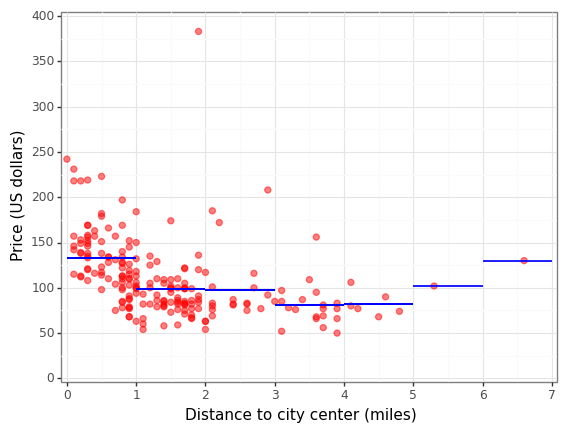

<ggplot: (678278042)>

In [23]:
p1 + geom_segment(
    aes(x="dist7_s", y="yend", xend="xend", yend="yend"),
    color="blue",
    size=0.7,
    na_rm=True,
)

###  Lowess Non-parametric Regression

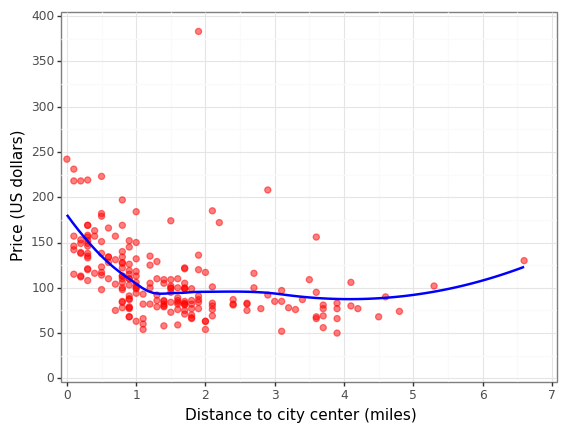

<ggplot: (678282457)>

In [24]:
p1 + geom_smooth(aes(x="distance", y="price"), color="blue", method="loess", se=False)

- Advantage: \
   smooth curve which represent the pattern of association pretty flexibly!
-  Disadvantage: \
   no measurable properties: it smooth over the observations with an 'optimal' bandwidth.

**NOTE:** This codechunk results in error for Windows users. See: https://github.com/has2k1/scikit-misc/issues/12

### Simple Linear Regression

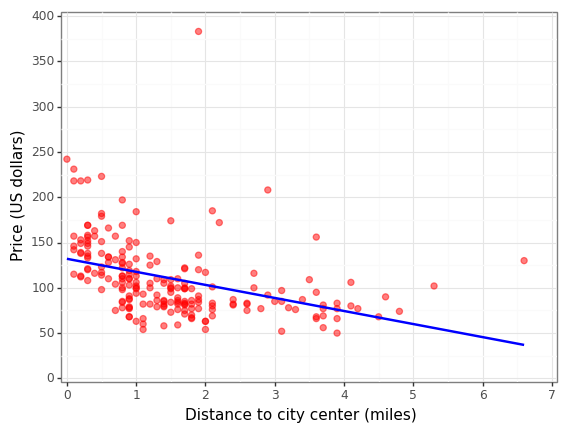

<ggplot: (678954521)>

In [25]:
p1 + geom_smooth(
    aes(x="distance", y="price"), method="lm", color="blue", formula="y~x", se=False
)

How to quantify linear regression: \
Remember: $y = \alpha + \beta * x + \epsilon$

In Python, the [statsmodels](https://www.statsmodels.org/stable/index.html) package is usually used to estimate regressions

In [26]:
import statsmodels.formula.api as smf
from mizani.formatters import percent_format

We use the statsmodels formula api, where you can give the equations as a string

 Simple model, with homoskedastic SE

In [27]:
simple_reg = smf.ols("price ~ distance", data=hotels).fit()
print(simple_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.39e-09
Time:                        10:33:42   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.0

Simple model, with heteroskedastic robust SE

In [28]:
hetero_rob_reg = smf.ols("price ~ distance", data=hotels).fit(cov_type ="HC3")
print(hetero_rob_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     28.10
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.97e-07
Time:                        10:33:42   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.876     27.072      0.0

Its wasy to compare two regression output tables using the stargazer package

In [29]:
from stargazer.stargazer import Stargazer

In [30]:
table = Stargazer([simple_reg, hetero_rob_reg])
table.rename_covariates({"Intercept": "Constant"})
table.custom_columns(["Homoskedastic SE", "Heteroskedastic robust SE"], [1, 1])
table

### Analysis of the Results
   - price prediction of a model
   - errors of predictions

It is easy to save the predicted values and residuals

In [31]:
hotels["predprice"] = simple_reg.fittedvalues
hotels["e"] = simple_reg.resid

Get the hotel, which is the most underpriced

In [32]:
hotels.sort_values(by="e").head(1)

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,dist4,Eprice_cat4,dist4_s,xend,yend,dist7_new,Eprice_cat7_new,dist7_s,predprice,e
153,Austria,Vienna,63.0,City centre,Donauturm,Josefstadt,54,Vienna,3.0,3.0,...,1.5,98.855263,1,2,98.855263,1.5,98.855263,1,116.16991,-62.16991


probably we are only interested in hotel_id, distance, price, prediction and error values:

In [33]:
hotels.sort_values(by="e").head(1).filter(["hotel_id","distance","price","predprice","e"])

,hotel_id,distance,price,predprice,e
153,22080,1.1,54,116.16991,-62.16991


 Interpret the result!

We can get the 5 most overpriced five hotels

In [34]:
hotels.sort_values(by="e", ascending=False).head(5).filter(
    ["hotel_id", "distance", "price", "predprice", "e"]
)

,hotel_id,distance,price,predprice,e
247,22193,1.9,383,104.644774,278.355226
26,21930,2.9,208,90.238353,117.761647
128,22050,0.0,242,132.016973,109.983027
110,22031,0.1,231,130.576331,100.423669
129,22051,0.5,223,124.813762,98.186238


Checking the histogram of residuals:\
we can better understand about how well we can predict the prices\
notes:\
   - we picked previously the smallest and 5 largest values from here
   - on average we will have 0 error, as this is a property of the OLS estimator

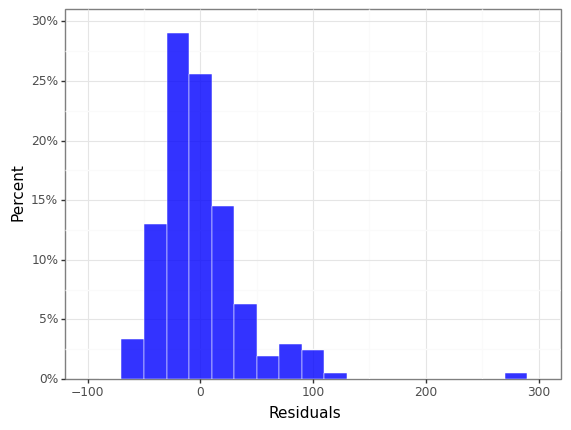

<ggplot: (679162091)>

In [35]:
(
    ggplot(hotels, aes(x="e"))
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        binwidth=20,
        fill="blue",
        color="white",
        size=0.2,
        alpha=0.8,
        na_rm=True,
    )
    + labs(x="Residuals", y="Percent")
    + scale_x_continuous(limits=(-100, 300), breaks=np.arange(-100, 301, 100))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.31),
        breaks=np.arange(0, 0.31, 0.05),
        labels=percent_format(),
    )
    + theme_bw()
)

We can make a pretty graph with the bottom and top 5 deals:

Create a factor variable with 4 possible values

In [36]:
hotels["reg1_res"] = np.where(hotels["e"] >= 0, "overpriced", "underpriced")

hotels["reg1_res"] = np.where(
    hotels["hotel_id"].isin(
        hotels.sort_values(by="e", ascending=False).head(5)["hotel_id"].tolist()
    ),
    "top5",
    hotels["reg1_res"],
)
hotels["reg1_res"] = np.where(
    hotels["hotel_id"].isin(
        hotels.sort_values(by="e", ascending=False).tail(5)["hotel_id"].tolist()
    ),
    "bottom5",
    hotels["reg1_res"],
)

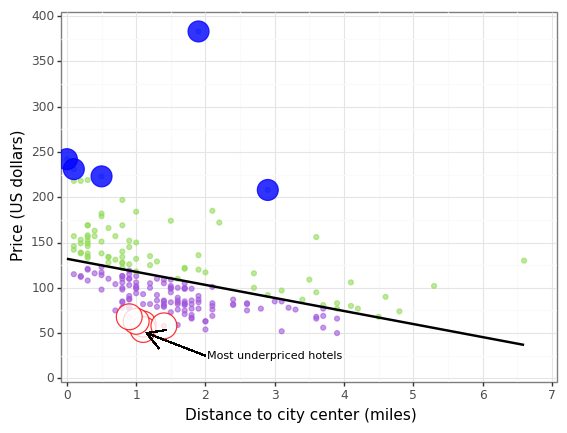

<ggplot: (679210834)>

In [37]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(aes(color="reg1_res"), alpha=0.6)
    + geom_point(
        hotels.loc[lambda x: x["reg1_res"] == "top5"], alpha=0.8, size=8, color="blue"
    )
    + geom_point(
        hotels.loc[lambda x: x["reg1_res"] == "bottom5"],
        alpha=0.8,
        size=10,
        color="red",
        fill="white",
    )
    + geom_smooth(method="lm", size=1, se=False, formula="y~x")
    + coord_cartesian(xlim=(0, 7), ylim=(0, 400))
    + expand_limits(x=0.01, y=0.01)
    + scale_color_discrete(guide=False)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 8, 1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + geom_segment(aes(x=2, y=25, xend=1.15, yend=50), arrow=arrow())
    + annotate("text", x=3, y=25, label="Most underpriced hotels", size=8)
    + theme_bw()
)

## Log models 

Take log price

In [38]:
hotels["lnprice"] = np.log(hotels["price"])

Correct distance2 measure: no closer than 0.05km

In [39]:
hotels["distance2"] = np.where(hotels["distance"] < 0.05, 0.05, hotels["distance"])

Take the log of distance2

In [40]:
hotels["lndistance"] = np.log(hotels["distance2"])

Describe price and ln price

In [41]:
hotels.filter(["price", "lnprice"]).describe(percentiles=[0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,25%,50%,75%,95%,max
price,207.0,109.975845,42.221381,50.000000,82.000000,100.00000,129.500000,183.400000,383.000000
lnprice,207.0,4.640219,0.336751,3.912023,4.406719,4.60517,4.863673,5.211657,5.948035


### Running multiple regressions:

1. Level-level linear regression

In [42]:
reg1 = smf.ols("price ~ distance", data=hotels).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.39e-09
Time:                        10:33:42   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.0

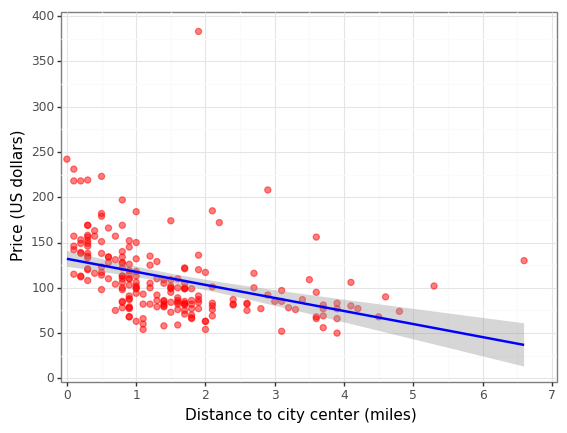

<ggplot: (678062933)>

In [43]:
f1 = p1 + geom_smooth(
    aes(x="distance", y="price"), method="lm", color="blue", formula="y~x", se=True
)
f1

2. Level-log linear regression

In [44]:
reg2 = smf.ols("price ~ lndistance", data=hotels).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     79.58
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.61e-16
Time:                        10:33:43   Log-Likelihood:                -1034.1
No. Observations:                 207   AIC:                             2072.
Df Residuals:                     205   BIC:                             2079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.4171      2.512     44.757      0.0

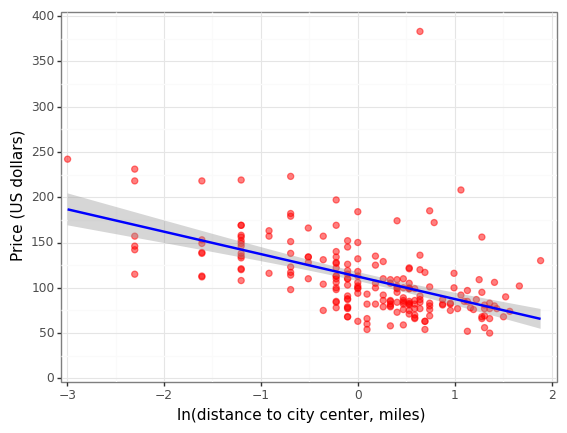

<ggplot: (677331330)>

In [45]:
f2 = (
    ggplot(data=hotels)
    + geom_point(aes(x="lndistance", y="price"), color="red", size=2, alpha=0.5)
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(-3, 2), breaks=range(-3, 3))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + labs(x="ln(distance to city center, miles)", y="Price (US dollars)")
    + theme_bw()
    + geom_smooth(
        aes(x="lndistance", y="price"),
        method="lm",
        color="blue",
        formula="y~x",
        se=True,
    )
)
f2

3. Log-level linear regression

In [46]:
reg3 = smf.ols("lnprice ~ distance", data=hotels).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     52.90
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           7.30e-12
Time:                        10:33:43   Log-Likelihood:                -44.160
No. Observations:                 207   AIC:                             92.32
Df Residuals:                     205   BIC:                             98.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8411      0.035    139.720      0.0

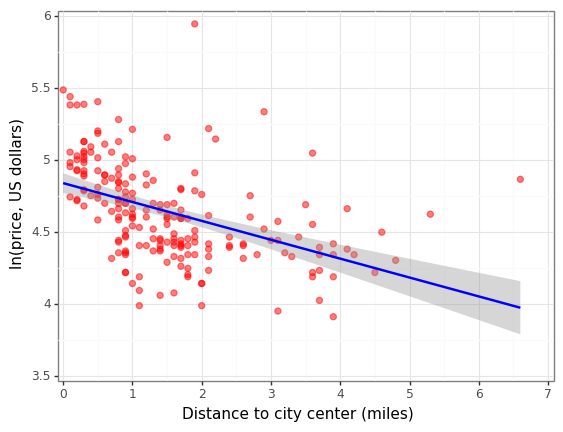

<ggplot: (680441082)>

In [47]:
f3 = (
    ggplot(data=hotels)
    + geom_point(aes(x="distance", y="lnprice"), color="red", size=2, alpha=0.5)
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=range(0, 8))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(3.5, 6), breaks=np.arange(3.5, 7, 0.5)
    )
    + labs(x="Distance to city center (miles)", y="ln(price, US dollars)")
    + theme_bw()
    + geom_smooth(
        aes(x="distance", y="lnprice"),
        method="lm",
        color="blue",
        formula="y~x",
        se=True,
    )
)
f3

4. Log-log linear regression

In [48]:
reg4 = smf.ols("lnprice ~ lndistance", data=hotels).fit()
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     102.6
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           8.18e-20
Time:                        10:33:43   Log-Likelihood:                -25.911
No. Observations:                 207   AIC:                             55.82
Df Residuals:                     205   BIC:                             62.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6615      0.019    241.926      0.0

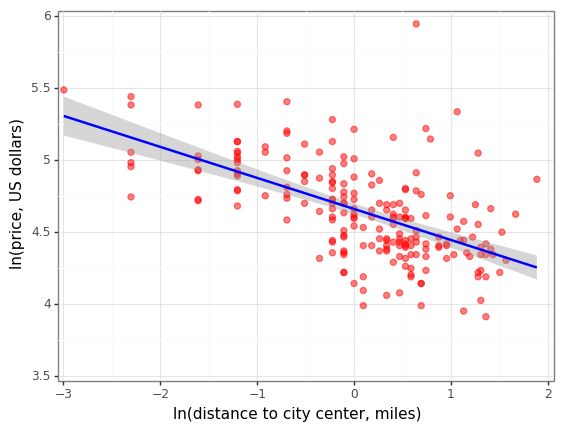

<ggplot: (680570871)>

In [49]:
f4 = (
    ggplot(data=hotels)
    + geom_point(aes(x="lndistance", y="lnprice"), color="red", size=2, alpha=0.5)
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(-3, 2), breaks=range(-3, 3))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(3.5, 6), breaks=np.arange(3.5, 7, 0.5)
    )
    + labs(x="ln(distance to city center, miles)", y="ln(price, US dollars)")
    + theme_bw()
    + geom_smooth(
        aes(x="lndistance", y="lnprice"),
        method="lm",
        color="blue",
        formula="y~x",
        se=True,
    )
)
f4

#### Checking and comparing all models:


In [50]:
table = Stargazer([reg1, reg2, reg3, reg4])
table.rename_covariates({"Intercept": "Constant"})
table.custom_columns(["Level-Level", "Level-Log", "Log-Level", "Log-Log"], [1, 1, 1, 1])
table

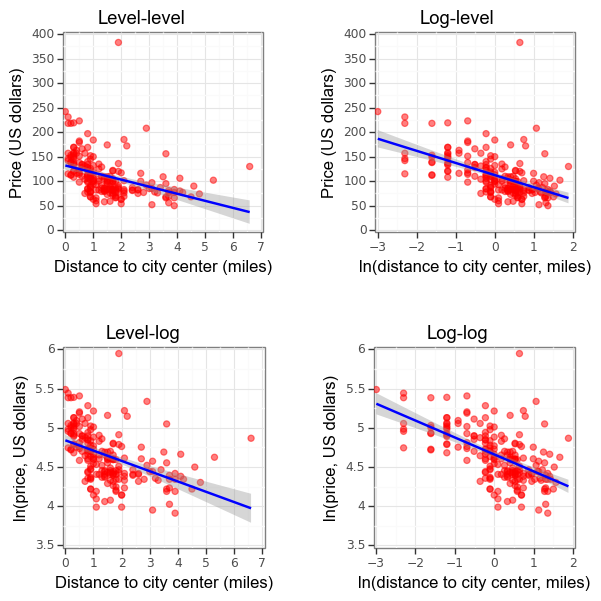

In [51]:
g1 = pw.load_ggplot(f1 + ggtitle("Level-level"), figsize=(2, 2))
g2 = pw.load_ggplot(f2 + ggtitle("Log-level"), figsize=(2, 2))
g3 = pw.load_ggplot(f3 + ggtitle("Level-log"), figsize=(2, 2))
g4 = pw.load_ggplot(f4 + ggtitle("Log-log"), figsize=(2, 2))

glog = (g1 | g2) / (g3 | g4)
glog.savefig()

## Polynomials

In [52]:
hotels["dist_sq"] = hotels["distance"]**2
hotels["dist_cb"] = hotels["distance"]**3

5. Single squared

In [53]:
reg5 = smf.ols("price ~ distance + dist_sq", data=hotels).fit()
print(reg5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     35.44
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           6.18e-14
Time:                        10:33:44   Log-Likelihood:                -1037.1
No. Observations:                 207   AIC:                             2080.
Df Residuals:                     204   BIC:                             2090.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    154.8580      6.045     25.617      0.0

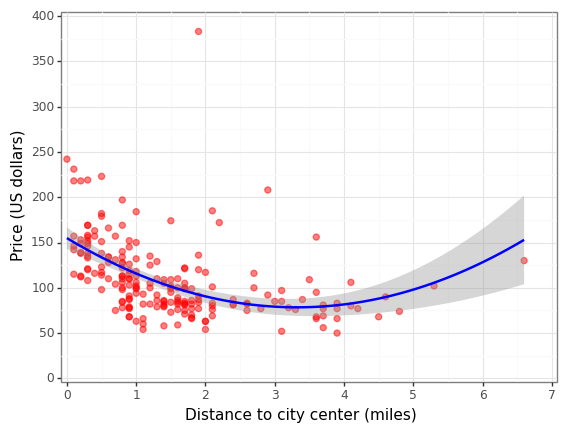

<ggplot: (681027497)>

In [54]:
f5 = p1 + geom_smooth(
    aes(x="distance", y="price"),
    method="lm",
    color="blue",
    formula="y ~ x + np.power(x, 2)",
    se=True,
)
f5

6. Squared and cubic

In [55]:
reg6 = smf.ols("price ~ distance + dist_sq + dist_cb", data=hotels).fit()
print(reg6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     25.74
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.75e-14
Time:                        10:33:44   Log-Likelihood:                -1034.6
No. Observations:                 207   AIC:                             2077.
Df Residuals:                     203   BIC:                             2091.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    165.6994      7.715     21.477      0.0

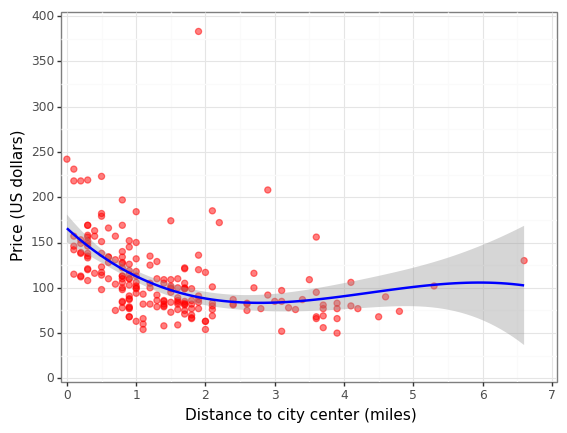

<ggplot: (680901057)>

In [56]:
f6 = p1 + geom_smooth(
    aes(x="distance", y="price"),
    method="lm",
    color="blue",
    formula="y ~ x + np.power(x, 2) + np.power(x, 3)",
    se=True,
)
f6

7. Spline

In [57]:
import copy
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

In [58]:
cutoff = 2

In [59]:
reg7 = smf.ols("price ~ lspline(distance, cutoff)", data=hotels).fit()
print(reg7.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     32.57
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.30e-13
Time:                        10:33:44   Log-Likelihood:                -1039.3
No. Observations:                 207   AIC:                             2085.
Df Residuals:                     204   BIC:                             2095.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

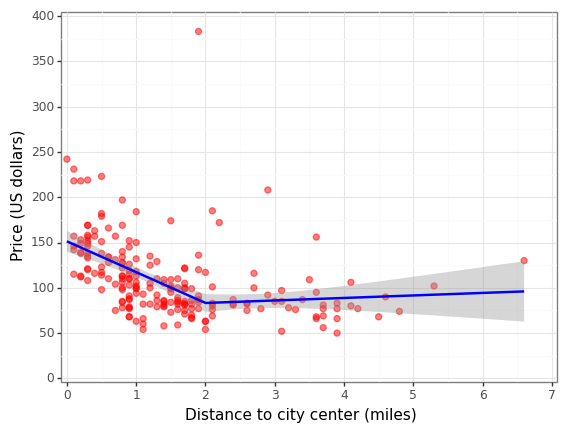

<ggplot: (680440878)>

In [60]:
f7 = p1 + geom_smooth(
    aes(x="distance", y="price"),
    method="lm",
    color="blue",
    formula="y ~ lspline(x, cutoff)",
    se=True,
)
f7

Compare these non-linear models:

In [61]:
table = Stargazer([reg1, reg5, reg6, reg7])
table.rename_covariates({"Intercept": "Constant"})
table.custom_columns(["Linear", "Squared", "Cubic", "L.Spline"], [1, 1, 1, 1])
table

In [62]:
g1 = pw.load_ggplot(f1 + ggtitle("Linear"), figsize=(2, 2))
g5 = pw.load_ggplot(f5 + ggtitle("Squared"), figsize=(2, 2))
g6 = pw.load_ggplot(f6 + ggtitle("Cubic"), figsize=(2, 2))
g7 = pw.load_ggplot(f7 + ggtitle("L.Spline"), figsize=(2, 2))

gpoly = (g1 | g5) / (g6 | g7)

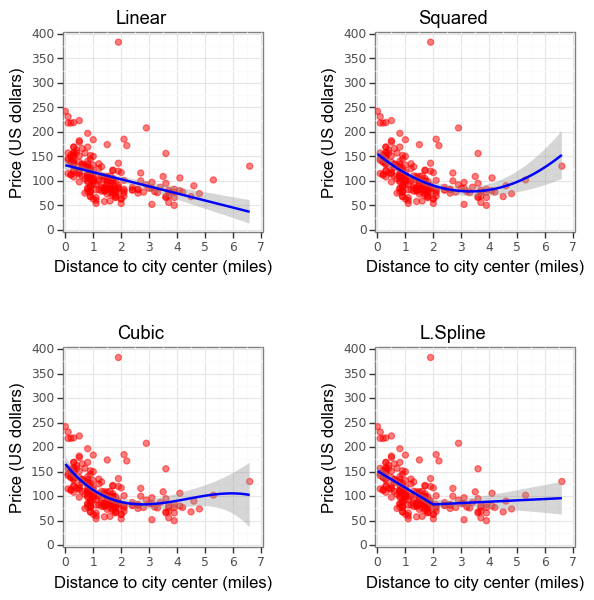

In [63]:
gpoly.savefig()